In [2]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.util import object_identity

In [3]:
PATHS = {
    'train': 'kaggle/input/deepglobe-road-extraction-dataset/train',
    'val': 'kaggle/input/deepglobe-road-extraction-dataset/valid',
    'test': 'kaggle/input/deepglobe-road-extraction-dataset/test',
}

IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 1
NUM_EPOCHS = 40
BATCH_SIZE = 64

In [4]:
csv_ds = pd.read_csv('/kaggle/input/deepglobe-road-extraction-dataset/metadata.csv')
images = []
masks = []

for idx, row in csv_ds.iterrows():
    _, set, path_img, path_mask = row
    if set == 'train':
        path_img = path_img.strip()
        path_img = os.path.join('/kaggle/input/deepglobe-road-extraction-dataset', path_img)
        if not os.path.exists(path_img): continue

        path_mask = path_mask.strip()
        path_mask = os.path.join('/kaggle/input/deepglobe-road-extraction-dataset', path_mask)
        if not os.path.exists(path_mask): continue
        
        img = cv2.imread(path_img)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape((IMG_HEIGHT, IMG_WIDTH, 1))
        img = img.astype('float16')
        img /= 255.

        mask = cv2.imread(path_mask)
        mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = mask.astype('float16')
        mask /= 255.

        images.append(img)
        masks.append(mask)

In [5]:
images = np.array(images)

masks = np.array(masks)
masks = masks[:, :, :, :1]
masks[masks>0.5] = 1
masks[masks<=0.5] = 0

In [6]:
images.shape, masks.shape

((6226, 256, 256, 1), (6226, 256, 256, 1))

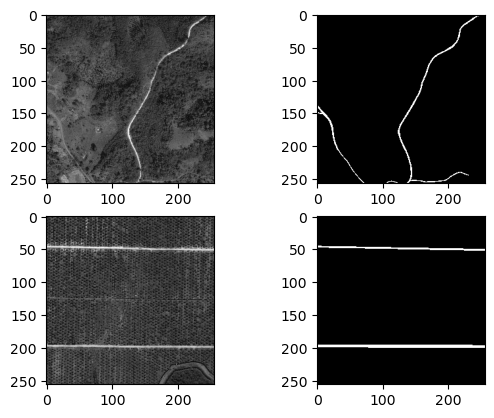

In [7]:
f = plt.figure()

num_of_images = 2
n = 0
for i in range(num_of_images):
    n += 1
    f.add_subplot(num_of_images, 2, n)
    plt.imshow(images[i], 'gray')
    n += 1
    f.add_subplot(num_of_images, 2, n)
    plt.imshow(masks[i], 'gray')

In [8]:
n_images = len(images)
val_split = int(0.8*n_images)
test_split = int(0.9*n_images)

train_images = images[:val_split]
train_masks = masks[:val_split]

val_images = images[val_split:test_split]
val_masks = masks[val_split:test_split]

test_images = images[test_split:]
test_masks = masks[test_split:]

In [9]:
generator = tf.keras.preprocessing.image.ImageDataGenerator()
train_gen = generator.flow(train_images, train_masks)
val_gen = generator.flow(val_images, val_masks)

In [10]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [12]:
def conv_block(input, filters):
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    return x

def encoder_block(input, filters):
    c = conv_block(input, filters)
    x = tf.keras.layers.MaxPool2D((2, 2))(c)
    return c, x

def decoder_block(input, input2, filters):
    x = conv_block(input, filters)
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), 2, padding="same")(x)
    x = tf.keras.layers.concatenate([x, input2])
    return x

def build_unet(filters_start_with):
    input = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    c1, x = encoder_block(input, filters_start_with*2**0)
    c2, x = encoder_block(x, filters_start_with*2**1)
    c3, x = encoder_block(x, filters_start_with*2**2)
    c4, x = encoder_block(x, filters_start_with*2**3)
    x = decoder_block(x, c4, filters_start_with*2**4)
    x = decoder_block(x, c3, filters_start_with*2**3)
    x = decoder_block(x, c2, filters_start_with*2**2)
    x = decoder_block(x, c1, filters_start_with*2**1)
    x = conv_block(x, filters_start_with*2**0)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[input], outputs=[output])
    return model

In [14]:
def compile_and_fit(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=dice_coef_loss, metrics=['binary_accuracy', dice_coef])
    hist = model.fit_generator(train_gen, validation_data=val_gen, epochs=75)
    model.save_weights(f'model_{model.layers[1].filters}.h5')
    return model, hist

In [15]:
def calculate_number_of_parameters(model):
    return int(sum(np.prod(p.shape.as_list())
      for p in object_identity.ObjectIdentitySet(model.trainable_weights)))

In [22]:
model = build_unet(16)
no_trainable_parameters = calculate_number_of_parameters(model)
print('Trainable parameters: ', no_trainable_parameters)

model1, hist1 = compile_and_fit(model)

Trainable parameters:  2310977
Epoch 1/100


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
2023-04-14 15:18:09.490692: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_90/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


156/156 [==============================] - 116s 437ms/step - loss: -0.1418 - binary_accuracy: 0.5976 - dice_coef: 0.1416 - val_loss: -0.1685 - val_binary_accuracy: 0.9026 - val_dice_coef: 0.1675
Epoch 2/100
156/156 [==============================] - 67s 427ms/step - loss: -0.2429 - binary_accuracy: 0.8804 - dice_coef: 0.2430 - val_loss: -0.3156 - val_binary_accuracy: 0.9505 - val_dice_coef: 0.3175
Epoch 3/100
156/156 [==============================] - 67s 431ms/step - loss: -0.4088 - binary_accuracy: 0.9402 - dice_coef: 0.4089 - val_loss: -0.4678 - val_binary_accuracy: 0.9584 - val_dice_coef: 0.4689
Epoch 4/100
156/156 [==============================] - 67s 433ms/step - loss: -0.4891 - binary_accuracy: 0.9510 - dice_coef: 0.4892 - val_loss: -0.5348 - val_binary_accuracy: 0.9596 - val_dice_coef: 0.5344
Epoch 5/100
156/156 [==============================] - 67s 432ms/step - loss: -0.5245 - binary_accuracy: 0.9552 - dice_coef: 0.5243 - val_loss: -0.5259 - val_binary_accuracy: 0.9589 - val

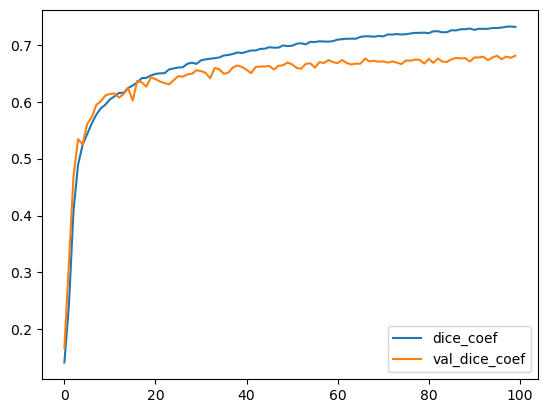

In [28]:
plt.plot(hist1.history['dice_coef'], label='dice_coef')
plt.plot(hist1.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.show()

In [32]:
predicted_masks = model1.predict(test_images)
dice_coef(tf.cast(test_masks, 'float32'), tf.cast(predicted_masks, 'float32'))

20/20 [==============================] - 2s 81ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.69079375>

In [ ]:
plt.plot(hist2.history['dice_coef'], label='dice_coef')
plt.plot(hist2.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.show()